In [1]:
import numpy as np #numpy for arrays

import matplotlib.pyplot as plt #for plotting

import seaborn as sns #for prettier plots
sns.set_style('darkgrid') #darkgrid for easier readability of plots
from mpl_toolkits import mplot3d #for 3d plots

#seq_col_brew = sns.color_palette("Greys_r", 20)
#sns.set_palette(seq_col_brew)

In [2]:
#stack overflow, thank youuuuu
#An altered function to read matlab structures on python nd recast them into proper dictionaries
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [3]:
#testing the loadmat function
test_mat = loadmat('/Users/lakshmipriyaswaminathan/Dropbox (OIST)/PILOT_S6_M6_MC10_TREADMILL_14_04_2020_processed_gapfilled.mat')



In [4]:
def access_data(mat_dictionary,type_data='trajectories',trajectories_masked=False):
    """A function to access the labeled trajectory data in the matlab structure after it
    has been converted into a python dicitonary"""
    
    #first we obtain the keys of the dictionary. 
    #Due to the way in which QTM saves it's files, the fourth key (index 3) contains the data.
    
    keys = list(mat_dictionary.keys())
    
    if type_data == 'trajectories': #to access 3d trajectory data
        trajectories = mat_dictionary[keys[3]]['Trajectories']['Labeled']['Data']
        if trajectories_masked == True:
            trajectories = np.ma.masked_invalid(trajectories)
            #print('Masking trajectories')
        else:
            trajectories=trajectories
        #print('Getting the trajectories!')
        return trajectories
    
    elif type_data == 'labels': #to access label names
        labels = mat_dictionary[keys[3]]['Trajectories']['Labeled']['Labels']
        #print('Getting the marker labels!')
        return labels
        
    elif type_data == 'frames':
        frames = mat_dictionary[keys[3]]['Frames']
        frame_rate = mat_dictionary[keys[3]]['FrameRate']
        #print('Getting the frames and frame rate (in that order)!')
        return frames, frame_rate
    
    elif type_data == 'everything':
        frames = mat_dictionary[keys[3]]['Frames']
        frame_rate = mat_dictionary[keys[3]]['FrameRate']
        labels = mat_dictionary[keys[3]]['Trajectories']['Labeled']['Labels']
        trajectories = mat_dictionary[keys[3]]['Trajectories']['Labeled']['Data']
        #print('Getting the: 0. frames, 1. frame rate, 2. labels, and 3. trajectories!')
        return frames, frame_rate, labels, trajectories
    else:
        raise ValueError('I can only access frames, frame rate, labels and trajectories')
    
        
        


In [5]:
marker_trajectories = access_data(test_mat, type_data='trajectories')

In [6]:
labels = access_data(test_mat, type_data='labels')

In [7]:
labels

array(['Coordinate_right', 'Hip_left', 'Hip_right', 'Knee_right',
       'Ankle_right', 'Back_left', 'Back_right', 'Knee_left',
       'Coordinate_left', 'Ankle_left'], dtype=object)

In [8]:
def single_marker_trajectories(mat_structure, marker_name, masked=False):
    """A function to access single marker trajectories and define them as arrays 
    that can be used in later analysis"""
    
    mls = access_data(mat_structure,type_data='labels') #accessing marker labels
    #now we access the right trajectory
    for i in range(len(mls)):
        #print(mls[i])
        if str(marker_name) == mls[i]:
            #print(mls[i])
            mi = i
            #print(i)
        #else:
         #   return 'Something is wrong with the spelling'
    #we access the trajectories
    marker_traj = access_data(mat_structure,type_data='trajectories',trajectories_masked=masked)[mi]
    
    return marker_traj
    

In [9]:
Coordinate_right_uma = single_marker_trajectories(test_mat, 'Coordinate_right', masked=False)
Hip_left_uma = single_marker_trajectories(test_mat, 'Hip_left', masked=False)
Hip_right_uma = single_marker_trajectories(test_mat, 'Hip_right', masked=False)
Knee_right_uma = single_marker_trajectories(test_mat, 'Knee_right', masked=False)
Ankle_right_uma = single_marker_trajectories(test_mat, 'Ankle_right', masked=False)
Back_left_uma = single_marker_trajectories(test_mat, 'Back_left', masked=False)
Back_right_uma = single_marker_trajectories(test_mat, 'Back_right', masked=False)
Knee_left_uma = single_marker_trajectories(test_mat, 'Knee_left', masked=False)
Coordinate_left_uma = single_marker_trajectories(test_mat, 'Coordinate_left', masked=False)
Ankle_left_uma = single_marker_trajectories(test_mat, 'Ankle_left', masked=False)

In [10]:
np.shape(marker_trajectories)

(10, 4, 19500)

In [11]:
single_frame = marker_trajectories[:,:3,4001]

In [12]:
def PCA(timeseries):
    #mean subtract things
    a,b = np.shape(timeseries)
    if a>b:
        N=a
        d=b
        
    else:
        d=a
        N=b
        timeseries = np.transpose(timeseries)
    timeseries_mean0 = np.zeros((N,d))
    for i in range(d):
        timeseries_mean0[:,i] = timeseries[:,i] - np.nanmean(timeseries[:,i])
        print(i)
        
    #now after mean subtraction we get the covariance matrix of stuff
    covT = np.cov(timeseries_mean0)
    print('covariance_done')
    
    #finally PCA part
    PCvecs,PCs, v = np.linalg.svd(covT)
    #normalising the PCs
    
    normPCs = PCs/sum(PCs)
    sortedpcs = (np.sort(normPCs))[::-1]
    
    return sortedpcs, PCvecs

## Coordinate transform

In [13]:
#First we need to define functions to compute midpoints between two markers, more specifically the hips
def midpoint(marker1, marker2):
    a1,b1 = np.shape(marker1)
    a2,b2 = np.shape(marker2)
    #another step to make sure that both timeseries have the same length
    if b2!=b1:
        if b2>b1:
            marker2 = marker2[:,:b1]
            dl = b1
        elif b1>b2:
            marker1 = marker1[:,:b2]
            dl = b2
        
    
    if a1>b1:
        marker1 = np.transpose(marker1)
    if a2>b2:
        marker2 = np.transpose(marker2)
    if a2!=a1:
        raise ValueError('Dimensions don\'t match!')
    
        
    #now we define a dummy array for the mid point
    midpoint_array = (marker1+marker2)/2
    midpoint_array_masked = ma.masked_invalid(midpoint_array)
    return midpoint_array_masked
    

In [14]:
#now I define the vectors!
def basisvectors(m1,m2,m3,m4,ankle_l,ankle_r):
    #the idea is as follows: we define two vectors on the mouse body using the markers we already have
    #we need three markers to define this, the third vector we pick in such a way 
    #that the third makes them a set of linearly independent vectors,
    #we can now use these as our transformation matrix and transform all the other trajectory point suing that
    
    #easy part defining the two vectors
    #m1,m2,m3,m4 = coord_system #extracting the 3 markers from the array
    
    midpoint1 = (m1+m2)/2 #the two hip markers
    midpoint2 = (m3+m4)/2 #the two back markers
    ankle = (ankle_l +ankle_r)/2
    #now we define the directional vector between these two midpoints, the other vector is between the hip markers
    hh = (midpoint1 - m2)
    hb = midpoint2 - midpoint1
    #that gives us two vectors out of the 3
    #now we compute the cross product, and the right hand rule will help! m1 should be the right hip :) nopeee
    #need to use the ankle to decide what's going on
    
    hu_1 = np.cross(hh,hb)
    hu_2 = np.cross(hb,hh)
    #we check the projection on the vector 
    ha = ankle - midpoint1
    proj_ha_hu_1 = np.dot(ha,hu_1)/np.dot(ha,ha)
    #print(proj_ha_hu_1)
    
    proj_ha_hu_2 = np.dot(ha,hu_2)/np.dot(ha,ha)
    #print(proj_ha_hu_2)
    if proj_ha_hu_1 <0: #i.e the z direction is the oppostie
        hu = hu_1
    elif proj_ha_hu_2 <0:
        hu = hu_2
    else:
        raise ValueError('Something is wrong....?')
    #we normalise each vector!!
    hh_norm = hh/np.linalg.norm(hh)
    hb_norm = hb/np.linalg.norm(hb)
    hu_norm = hu/np.linalg.norm(hu)
    
    #finally we combine the 3 vectors two get our basis set
    basis_set = np.transpose(np.vstack((hh_norm,hb_norm,hu_norm)))
    return basis_set, midpoint1
    #we have to loop over this somehow...
    

In [15]:
#ok so all of the above gives us a timeseries of the vectors that we need that are not orthonormal, 
#so after every transformation matrix that we compute I need to orthogonalize them
def gram_schmidt_orthogonalisation(vectors):
    """A function to orthogonalise a set of given vectors"""
    #we are only considering 3d here
    ov1 = vectors[:,0]
    proj_v1_v2 = gram_schmidt_coefficient(vectors[:,0],vectors[:,1])
    ov2 = vectors[:,1] - proj_v1_v2
    proj_v1_v3 = gram_schmidt_coefficient(vectors[:,0],vectors[:,2])
    proj_v2_v3 = gram_schmidt_coefficient(vectors[:,1], vectors[:,2])
    ov3 = vectors[:,2] - proj_v1_v3 - proj_v2_v3
    return np.transpose(np.vstack((ov1,ov2,ov3)))

In [16]:
test_ct, test_o = basisvectors(Hip_left_uma[:3,1500],Hip_right_uma[:3,1500],Coordinate_left_uma[:3,1500],Coordinate_right_uma[:3,1500],Ankle_left_uma[:3,1500], Ankle_right_uma[:3,1500])

In [17]:
test_ct, test_o

(array([[-0.16822348, -0.90258774,  0.29024717],
        [-0.88485163,  0.1570565 , -0.46564589],
        [-0.4344404 ,  0.40083491,  0.83602063]]),
 array([282.67631769,  12.27589121,   6.66017906]))

In [18]:
def gram_schmidt_coefficient(v1,v2):
    """Computes the projection of v1 on v2"""
    gsc = (np.dot(v1,v2)/np.dot(v1,v1))*(v1)
    
    return gsc

In [23]:
test_ct_ortho = gram_schmidt_orthogonalisation(test_ct)

In [24]:
test_ct_ortho_qr = np.linalg.qr(test_ct)[0]

In [25]:
test_ct_ortho

array([[-0.16822348, -0.92971784,  0.29024717],
       [-0.88485163,  0.01435282, -0.46564589],
       [-0.4344404 ,  0.33077092,  0.83602063]])

In [26]:
test_ct_ortho_qr

array([[-0.16822348,  0.9420496 ,  0.29024717],
       [-0.88485163, -0.0145432 , -0.46564589],
       [-0.4344404 , -0.33515825,  0.83602063]])

In [27]:
np.linalg.matrix_rank(test_ct_ortho_qr)

3

In [28]:
def basisvectors_time(m1,m2,m3,m4,al,ar):
    #each of the marker trajectories has to be 3xN
    #we check this
    a1,b1 = np.shape(m1)
    a2,b2 = np.shape(m2)
    a3,b3 = np.shape(m3)
    a4,b4 = np.shape(m4)
    if a1>b1:
        m1 = np.transpose(m1)
        N = a1
    elif a1<b1:
        N = b1
    if a2>b2:
        m2 = np.transpose(m2)
    if a3>b3:
        m3 = np.transpose(m3)
    if a4>b4:
        m4 = np.transpose(m4)
    # now we loop over N
    #computing the origin through time as well
    origin_ts = []
    T_matrix = []
    for i in range(N):
        ct_m= basisvectors(m1[:,i],m2[:,i],m3[:,i],m4[:,i],al[:,i],ar[:,i])
        ct_matrix = np.linalg.qr(ct_m[0])[0]
        if np.linalg.matrix_rank(ct_matrix) != 3:
            print (i)
            raise ValueError('Rank deficient matrix')
        T_matrix.append(ct_matrix)
        origin_ts.append(ct_m[1])
        
    return np.array(T_matrix), np.transpose(np.array(origin_ts))

In [29]:
test_ct_time, test_o_time = basisvectors_time(Hip_left_uma[:3,1500:],Hip_right_uma[:3,1500:],Coordinate_left_uma[:3,1500:],Coordinate_right_uma[:3,1500:],Ankle_left_uma[:3,1500:],Ankle_right_uma[:3,1500:])

In [30]:
np.shape(test_ct_time)

(18000, 3, 3)

In [31]:
np.shape(test_o_time)

(3, 18000)

In [32]:
Hip_left_uma[:3,1500] - test_o_time[:,0]

array([-0.96497574, -5.07575022, -2.49206857])

In [33]:
def coordinate_transform(tmatrix,torigin,trajectory):
    #the trajectory is a 1,3,N shaped array, so we loop over N
    #the tmatrix is 3*3,N, each column an animal centric basis vector
    a,b = np.shape(trajectory)
    if a>b:
        trajectory = np.transpose(trajectory)
        d = b
        a = N
    elif b>a:
        d = a
        N = b
    #now we loop over N
    coord_trans_traj = []
    for i in range(N):
        trajectory_0 = trajectory[:,i] - torigin[:,i]
        coord_trans_traj.append(np.matmul(tmatrix[i,:,:],trajectory_0))
    return np.transpose(coord_trans_traj)


        

In [34]:
test_coordinate_transform = coordinate_transform(test_ct_time,test_o_time ,Hip_left_uma[:3,1500:])

In [35]:
ankle_ct = coordinate_transform(test_ct_time, test_o_time,Ankle_left_uma[:3,1500:])

In [36]:
np.shape(test_coordinate_transform)

(3, 18000)

In [37]:
#for i in range(3):
 #       ankle_ct[:,i] = ankle_ct[:,i] - np.nanmean(ankle_ct[:,i])

In [38]:
test_ct_time[7989]

array([[-0.01961141, -0.81326977,  0.58155625],
       [ 0.78611668, -0.37194732, -0.49363524],
       [ 0.61776691,  0.44749018,  0.64661935]])

In [39]:
test_ct_time[7898]

array([[-0.05478665, -0.74597629,  0.66371515],
       [ 0.82740101, -0.4060064 , -0.38802884],
       [ 0.55893291,  0.52789978,  0.63946526]])

In [40]:
#let's do it for all of them

Hip_left_ct = coordinate_transform(test_ct_time,test_o_time, Hip_left_uma[:3,1500:])
Hip_right_ct = coordinate_transform(test_ct_time, test_o_time,Hip_right_uma[:3,1500:])
Coordinate_left_ct = coordinate_transform(test_ct_time,test_o_time, Coordinate_left_uma[:3,1500:])
Coordinate_right_ct = coordinate_transform(test_ct_time, test_o_time,Coordinate_right_uma[:3,1500:])
Back_left_ct = coordinate_transform(test_ct_time, test_o_time,Back_left_uma[:3,1500:])
Back_right_ct = coordinate_transform(test_ct_time, test_o_time,Back_right_uma[:3,1500:])
Knee_left_ct = coordinate_transform(test_ct_time, test_o_time,Knee_left_uma[:3,1500:])
Knee_right_ct = coordinate_transform(test_ct_time, test_o_time,Knee_right_uma[:3,1500:])
Ankle_left_ct = coordinate_transform(test_ct_time, test_o_time,Ankle_left_uma[:3,1500:])
Ankle_right_ct = coordinate_transform(test_ct_time, test_o_time,Ankle_right_uma[:3,1500:])

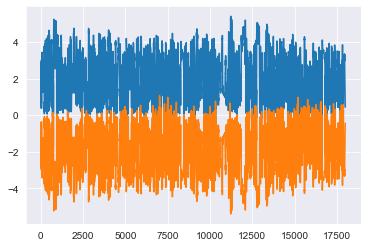

In [41]:
fig4 = plt.figure(4)

#plt.plot(test_coordinate_transform[0])
#plt.plot(Hip_left_uma[0,1500:])
#plt.plot(test_coordinate_transform[1])
plt.plot(test_coordinate_transform[1])

#plt.plot(Hip_right_ct[0])
#plt.plot(Hip_right_ct[1])
plt.plot(Hip_right_ct[1])
#plt.plot(ankle_ct[0])
#plt.plot(ankle_ct[1])
#plt.plot(ankle_ct[2])
#plt.plot(Ankle_left_uma[0,1500:])
plt.show()

In [42]:
ct_marker_traj = np.array([Hip_left_ct,Hip_right_ct,Coordinate_left_ct,Coordinate_right_ct,Back_left_ct,Back_right_ct,Knee_left_ct,Knee_right_ct,Ankle_left_ct,Ankle_right_ct])

In [43]:
np.shape(Hip_right_ct)

(3, 18000)

In [44]:
for i in range(3):
    print(np.mean(Hip_left_ct[i,:]))

-3.2412702538492635
2.17663862886468
-0.4894343024692982


In [45]:
Ankle = (Ankle_left_uma[:3,1500:] + Ankle_right_uma[:3,1500:])/2

In [46]:
labels_sf = ['H_l','H_r','C_l','C_r','B_l','B_r','K_l','K_r','A_l','A_r']

In [47]:
%matplotlib

Using matplotlib backend: MacOSX


In [48]:
fig6 = plt.figure(6)
ax = plt.axes(projection='3d')

#ax.plot3D(Ankle[0,:],Ankle[1,:],Ankle[2,:])
#ax.plot3D(Ankle_left_uma[0,1500:],Ankle_left_uma[1,1500:],Ankle_left_uma[3,1500:])
#ax.plot3D(Ankle_right_uma[0,1500:],Ankle_right_uma[1,1500:],Ankle_right_uma[3,1500:])

#ax.plot3D(Hip_left_ct[0,:],Hip_left_ct[1,:],Hip_left_ct[2,:])
#ax.plot3D(Hip_right_ct[0,:],Hip_right_ct[1,:],Hip_right_ct[2,:])
#ax.plot3D(Coordinate_left_ct[0,:],Coordinate_left_ct[1,:],Coordinate_left_ct[2,:])
#ax.plot3D(Coordinate_right_ct[0,:],Coordinate_right_ct[1,:],Coordinate_right_ct[2,:])
#ax.plot3D(Knee_left_ct[0,:],Knee_left_ct[1,:],Knee_left_ct[2,:])
#ax.plot3D(Knee_right_ct[0,:],Knee_right_ct[1,:],Knee_right_ct[2,:])
#ax.plot3D(Back_left_ct[0,:],Back_left_ct[1,:],Back_left_ct[2,:])
#ax.plot3D(Back_right_ct[0,:],Back_right_ct[1,:],Back_right_ct[2,:])
#ax.plot3D(Ankle_left_ct[0,:],Ankle_left_ct[1,:],Ankle_left_ct[2,:])
ax.scatter(ct_marker_traj[:,0,7],ct_marker_traj[:,1,7],ct_marker_traj[:,2,7])
for i in range(10):
    ax.text(ct_marker_traj[i,0,7], ct_marker_traj[i,1,7], ct_marker_traj[i,2,7], '%s' % (labels_sf[i]), size=10, zorder=1, color='k')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Text(0.5, 0, 'Z')

# Plotting the Mean pose

In [49]:
def mean_marker_pos(markertrajectory):
    a,b = np.shape(markertrajectory)
    if a<b:
        timeseries = markertrajectory
        dim = a
        timelen = b
    elif b<a:
        dim = b
        timelen = a
        timeseries = np.transpose(markertrajectory)
    else:
        raise ValueError("The timeseries seems to be too short")
    marker_mean = []
    for i in range(dim):
        marker_mean.append(np.mean(timeseries[i,:]))
    return marker_mean
    

In [50]:
mean_pose = np.empty((3,10))

In [51]:
for i in range(10):
    mean_pose[:,i] = mean_marker_pos(ct_marker_traj[i])

In [52]:
np.shape(mean_pose)

(3, 10)

In [53]:
ct_markertrajectories= np.reshape(ct_marker_traj[:,:,:],(30,18000))

In [54]:
mean_pose_meh = []

In [55]:
for i in range(30):
    mean_pose_meh.append(np.mean(ct_markertrajectories[i,:]))

In [56]:
for i in range(30):
    print(mean_pose_meh[i])

-3.2412702538492635
2.17663862886468
-0.4894343024692982
3.2412702538492635
-2.17663862886468
0.4894343024692982
1.0091918314864265
2.489746861761021
4.356525580278585
6.958451380582573
-1.2316347199533204
4.871536232143295
8.536610261418478
14.285931938944149
9.250507112524705
14.702737859257235
12.485984153176295
10.433296212582341
-7.195580680125672
12.56519123479777
-2.2907429794615037
9.237042853157897
4.291232367343567
-4.128618384944368
-9.529056288914282
12.215441340237138
-8.765871124885079
4.802461190899704
4.397519542121303
-11.68662422899364


In [57]:
mean_pose_meh_rs = np.reshape(mean_pose_meh,(10,3))

In [58]:
 for i in range(30):
         ct_markertrajectories[i,:] = ct_markertrajectories[i,:] - np.nanmean(ct_markertrajectories[i,:])

In [59]:
mean_posemeh_ar = np.array(mean_pose_meh_rs)

In [60]:
fig19 = plt.figure(19)
ax = plt.axes(projection='3d')
for i in range(10):
    ax.scatter(mean_posemeh_ar[i,0],mean_posemeh_ar[i,1],mean_posemeh_ar[i,2])
    ax.text(mean_posemeh_ar[i,0], mean_posemeh_ar[i,1], mean_posemeh_ar[i,2], '%s' % (labels_sf[i]), size=10, zorder=1, color='k')


In [61]:
np.shape(ct_marker_traj)

(10, 3, 18000)

In [62]:
ct_marker_traj[0,:,:10]

array([[-2.10132247e+00, -2.15450805e+00, -2.50405136e+00,
        -2.55441311e+00, -3.17527990e+00, -2.78243724e+00,
        -2.82252926e+00, -2.86293207e+00,  7.29227560e+00,
         7.21638303e+00],
       [-8.85391470e-02, -2.18456191e-01, -3.80973819e-01,
        -5.74048290e-01, -1.03376487e+00, -1.18820951e+00,
        -1.46942992e+00, -1.75556277e+00,  4.70063956e-03,
         2.18003315e-01],
       [ 5.26417600e-01,  4.25556024e-01,  4.86460504e-01,
         4.12934469e-01,  2.24018149e-01,  2.83040620e-01,
         1.63524602e-01,  4.20790253e-02, -3.57366118e+00,
        -3.55105777e+00]])

In [63]:
ct_markertrajectories[:3,:10]

array([[-2.10132247e+00, -2.15450805e+00, -2.50405136e+00,
        -2.55441311e+00, -3.17527990e+00, -2.78243724e+00,
        -2.82252926e+00, -2.86293207e+00,  7.29227560e+00,
         7.21638303e+00],
       [-8.85391470e-02, -2.18456191e-01, -3.80973819e-01,
        -5.74048290e-01, -1.03376487e+00, -1.18820951e+00,
        -1.46942992e+00, -1.75556277e+00,  4.70063956e-03,
         2.18003315e-01],
       [ 5.26417600e-01,  4.25556024e-01,  4.86460504e-01,
         4.12934469e-01,  2.24018149e-01,  2.83040620e-01,
         1.63524602e-01,  4.20790253e-02, -3.57366118e+00,
        -3.55105777e+00]])

In [64]:
#mean pose
for i in range(3):
    print(np.mean(ct_markertrajectories[i,:]))
    

1.4526651486650938e-16
-2.021099337273174e-16
7.579122514774402e-17


In [65]:
# ct_pcanalysis = PCA(ct_markertrajectories)

In [66]:
ct_cov = np.cov(ct_markertrajectories)

In [67]:
#np.shape(ct_cov)

In [68]:
#ct_cov

In [123]:
Pcct, Pcvecsct = np.linalg.eig(ct_cov)

In [124]:
np.shape(vct)

(30, 30)

In [125]:
#PCA_reconstructions

In [126]:
np.shape(mean_posemeh_ar)

(10, 3)

In [156]:
def PCA_reconstruction(meanpose, PCvecs, Pcs, num_sig=10):
    weighted_vecs = []
    for i in range(num_sig):
        a =(PCvecs[:,i]**2)*np.repeat(Pcs[i],30)
        weighted_vecs.append(np.reshape(a,(10,3)))
    weighted_vecs = np.array(weighted_vecs)
    pose_recon = []
    for i in range(num_sig):
        pose_recon.append(weighted_vecs[i]+meanpose)
    
    return np.array(pose_recon), weighted_vecs    
    #now we reshape
    #weighted_vecs = np.array(np.reshape(weighted_vecs,(10,3)))
    #now we add the mean
    #pose_reconstruction = meanpose + weighted_vecs
    #return pose_reconstruction
    
    

In [157]:
def PC_poses(PCvecs,num=10):
    pcposes = []
    for i in range(num):
        pcposes.append(np.reshape(PCvecs[:,i],(10,3)))
    return np.array(pcposes)

In [158]:
p_poses = PC_poses(Pcvecsct)

In [159]:
np.shape(p_poses)

(10, 10, 3)

In [160]:
test_recon,test_recon_vecs = PCA_reconstruction(mean_posemeh_ar, Pcvecsct, Pcct)

In [161]:
#simple scaling
test_simple,test_simple_vecs = PCA_reconstruction(mean_posemeh_ar, pcvecsct_norm, Pcct_norm*np.repeat(50,30))

In [162]:
np.cumsum(Pcct)

array([3894.04205741, 4067.49204187, 4143.60019944, 4170.14283414,
       4193.09588695, 4207.57034513, 4215.45525002, 4219.64782046,
       4222.90032275, 4226.02782   , 4228.0790122 , 4229.6492651 ,
       4230.74704562, 4231.65626925, 4232.2827393 , 4232.6945789 ,
       4233.01652148, 4233.27905118, 4233.46752688, 4233.59596517,
       4233.70546739, 4233.79906069, 4233.8747486 , 4233.9342019 ,
       4233.97663098, 4234.00074445, 4234.02695272, 4234.02695272,
       4234.02695272, 4234.02695272])

In [163]:
mean_posemeh_ar


array([[ -3.24127025,   2.17663863,  -0.4894343 ],
       [  3.24127025,  -2.17663863,   0.4894343 ],
       [  1.00919183,   2.48974686,   4.35652558],
       [  6.95845138,  -1.23163472,   4.87153623],
       [  8.53661026,  14.28593194,   9.25050711],
       [ 14.70273786,  12.48598415,  10.43329621],
       [ -7.19558068,  12.56519123,  -2.29074298],
       [  9.23704285,   4.29123237,  -4.12861838],
       [ -9.52905629,  12.21544134,  -8.76587112],
       [  4.80246119,   4.39751954, -11.68662423]])

In [164]:
test_simple_vecs

array([[[1.25179362e-01, 9.26501006e-03, 5.82744821e-02],
        [1.25179362e-01, 9.26501006e-03, 5.82744821e-02],
        [1.94221142e-01, 1.48645452e-01, 4.54163621e-01],
        [4.96898195e-02, 3.29483529e-01, 4.15996687e-02],
        [7.69737580e-02, 9.45766052e+00, 5.33835806e+00],
        [1.53351298e-01, 1.18791997e+01, 3.90990183e+00],
        [6.97857657e-01, 7.02029976e-01, 1.80756601e+00],
        [1.96930027e+00, 2.83702731e+00, 1.60269085e-02],
        [1.53352157e-01, 1.71344434e-01, 5.12174323e-01],
        [2.82770604e+00, 1.53662245e+00, 3.35394501e-01]],

       [[6.36274082e-05, 8.25544338e-03, 2.90664494e-03],
        [6.36274082e-05, 8.25544338e-03, 2.90664494e-03],
        [2.09400151e-02, 1.52232996e-02, 3.98235759e-05],
        [1.65196472e-02, 1.27131700e-03, 1.09138402e-02],
        [4.46168564e-01, 4.03270006e-02, 4.90908042e-02],
        [5.09166779e-01, 1.08866135e-02, 9.88842328e-02],
        [9.61145223e-02, 9.86948357e-02, 3.19411552e-03],
        [6.9

In [165]:
np.shape(test_simple)

(10, 10, 3)

In [166]:
labels_sf

['H_l', 'H_r', 'C_l', 'C_r', 'B_l', 'B_r', 'K_l', 'K_r', 'A_l', 'A_r']

In [167]:
np.cumsum(Pcct_norm*np.repeat(10,30))

array([ 9.19701764,  9.60667489,  9.78642849,  9.84911735,  9.90332828,
        9.93751431,  9.95613702,  9.96603911,  9.97372093,  9.98110751,
        9.98595205,  9.9896607 ,  9.99225346,  9.99440088,  9.99588049,
        9.99685318,  9.99761355,  9.99823359,  9.99867874,  9.99898209,
        9.99924071,  9.99946176,  9.99964052,  9.99978094,  9.99988115,
        9.99994305, 10.        , 10.        , 10.        , 10.        ])

In [168]:
fig99 = plt.figure(102)
ax = plt.axes(projection='3d')

ax.scatter(mean_posemeh_ar[:,0],mean_posemeh_ar[:,1],mean_posemeh_ar[:,2],'C0')
for pn in range(7):

    #ax.text(test_recon[0,:,0], test_recon[0,:,1], test_recon[0,:,2], '%s' % (labels_sf[i]), size=10, zorder=1, color='k')
    ax.scatter(test_recon[pn,:,0],test_recon[pn,:,1],test_recon[pn,:,2],('C'+str(pn+1)))
    ax.plot3D(test_recon[pn,:2,0],test_recon[pn,:2,1],test_recon[pn,:2,2],('C'+str(pn+1)))
    ax.plot3D(test_recon[pn,2:4,0],test_recon[pn,2:4,1],test_recon[pn,2:4,2],('C'+str(pn+1)))
    ax.plot3D(test_recon[pn,4:6,0],test_recon[pn,4:6,1],test_recon[pn,4:6,2],('C'+str(pn+1)))
    ax.plot3D(test_recon[pn,6::2,0],test_recon[pn,6::2,1],test_recon[pn,6::2,2],('C'+str(pn+1)))
    ax.plot3D(test_recon[pn,7::2,0],test_recon[pn,7::2,1],test_recon[pn,7::2,2],('C'+str(pn+1)))
    ax.plot3D(test_recon[pn,0::6,0],test_recon[pn,0::6,1],test_recon[pn,0::6,2],('C'+str(pn+1)))
    ax.plot3D(test_recon[pn,1::6,0],test_recon[pn,1::6,1],test_recon[pn,1::6,2],('C'+str(pn+1)))
ax.set_xlim3d([-15,15])
ax.set_ylim3d([-8,28])
ax.set_zlim3d([-15,15])
#ax.scatter(test_recon[1,:,0],test_recon[1,:,1],test_recon[1,:,2],'g')
#ax.scatter(test_recon[2,:,0],test_recon[2,:,1],test_recon[2,:,2],'g')
#ax.scatter(test_recon[3,:,0],test_recon[3,:,1],test_recon[3,:,2],'g')
#ax.scatter(test_recon[4,:,0],test_recon[4,:,1],test_recon[4,:,2],'g')
#ax.scatter(test_recon[5,:,0],test_recon[5,:,1],test_recon[5,:,2],'g')
ax.plot3D(mean_posemeh_ar[:2,0],mean_posemeh_ar[:2,1],mean_posemeh_ar[:2,2],'C0')
ax.plot3D(mean_posemeh_ar[2:4,0],mean_posemeh_ar[2:4,1],mean_posemeh_ar[2:4,2],'C0')
ax.plot3D(mean_posemeh_ar[4:6,0],mean_posemeh_ar[4:6,1],mean_posemeh_ar[4:6,2],'C0')
ax.plot3D(mean_posemeh_ar[6::2,0],mean_posemeh_ar[6::2,1],mean_posemeh_ar[6::2,2],'C0')
ax.plot3D(mean_posemeh_ar[7::2,0],mean_posemeh_ar[7::2,1],mean_posemeh_ar[7::2,2],'C0')
ax.plot3D(mean_posemeh_ar[0::6,0],mean_posemeh_ar[0::6,1],mean_posemeh_ar[0::6,2],'C0')
ax.plot3D(mean_posemeh_ar[1::6,0],mean_posemeh_ar[1::6,1],mean_posemeh_ar[1::6,2],'C0')

In [155]:
fig103 = plt.figure(103)

for i in range(10):
    plt.subplot(2,5,i+1)
    ax = plt.axes(projection='3d')
    ax.scatter(p_poses[i,:,0],p_poses[i,:,1],p_poses[i,:,2],('C'+str(i+1)))
    ax.plot3D(p_poses[i,:2,0],p_poses[i,:2,1],p_poses[i,:2,2],('C'+str(i+1)))
    ax.plot3D(p_poses[i,2:4,0],p_poses[i,2:4,1],p_poses[i,2:4,2],('C'+str(i+1)))
    ax.plot3D(p_poses[i,4:6,0],p_poses[i,4:6,1],p_poses[i,4:6,2],('C'+str(i+1)))
    ax.plot3D(p_poses[i,6::2,0],p_poses[i,6::2,1],p_poses[i,6::2,2],('C'+str(i+1)))
    ax.plot3D(p_poses[i,7::2,0],p_poses[i,7::2,1],p_poses[i,7::2,2],('C'+str(i+1)))
    ax.plot3D(p_poses[i,0::6,0],p_poses[i,0::6,1],p_poses[i,0::6,2],('C'+str(i+1)))
    ax.plot3D(p_poses[i,1::6,0],p_poses[i,1::6,1],p_poses[i,1::6,2],('C'+str(i+1)))
    #ax.set_xlim3d([-15,15])
    #ax.set_ylim3d([-8,28])
    #ax.set_zlim3d([-15,15])
plt.show()

Traceback (most recent call last):
  File "/Users/lakshmipriyaswaminathan/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 224, in process
    func(*args, **kwargs)
  File "/Users/lakshmipriyaswaminathan/miniconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py", line 1137, in _button_release
    toolbar = getattr(self.figure.canvas, "toolbar")
AttributeError: 'NoneType' object has no attribute 'canvas'
Traceback (most recent call last):
  File "/Users/lakshmipriyaswaminathan/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 224, in process
    func(*args, **kwargs)
  File "/Users/lakshmipriyaswaminathan/miniconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py", line 1137, in _button_release
    toolbar = getattr(self.figure.canvas, "toolbar")
AttributeError: 'NoneType' object has no attribute 'canvas'
Traceback (most recent call last):
  File "/Users/lakshmipriyaswaminathan/miniconda3/lib/python3.8/site-packag

In [121]:
fig99 = plt.figure(102)
ax = plt.axes(projection='3d')
pn=2
ax.scatter(mean_posemeh_ar[:,0],mean_posemeh_ar[:,1],mean_posemeh_ar[:,2],'C0')
#for pn in range(10):

    #ax.text(test_recon[0,:,0], test_recon[0,:,1], test_recon[0,:,2], '%s' % (labels_sf[i]), size=10, zorder=1, color='k')
ax.scatter(test_recon[pn,:,0],test_recon[pn,:,1],test_recon[pn,:,2],'C1')
ax.plot3D(test_recon[pn,:2,0],test_recon[pn,:2,1],test_recon[pn,:2,2],'C1')
ax.plot3D(test_recon[pn,2:4,0],test_recon[pn,2:4,1],test_recon[pn,2:4,2],'C1')
ax.plot3D(test_recon[pn,4:6,0],test_recon[pn,4:6,1],test_recon[pn,4:6,2],'C1')
ax.plot3D(test_recon[pn,6::2,0],test_recon[pn,6::2,1],test_recon[pn,6::2,2],'C1')
ax.plot3D(test_recon[pn,7::2,0],test_recon[pn,7::2,1],test_recon[pn,7::2,2],'C1')
ax.plot3D(test_recon[pn,0::6,0],test_recon[pn,0::6,1],test_recon[pn,0::6,2],'C1')
ax.plot3D(test_recon[pn,1::6,0],test_recon[pn,1::6,1],test_recon[pn,1::6,2],'C1')
ax.set_xlim3d([-15,15])
ax.set_ylim3d([-8,28])
ax.set_zlim3d([-15,15])
#ax.scatter(test_recon[1,:,0],test_recon[1,:,1],test_recon[1,:,2],'g')
#ax.scatter(test_recon[2,:,0],test_recon[2,:,1],test_recon[2,:,2],'g')
#ax.scatter(test_recon[3,:,0],test_recon[3,:,1],test_recon[3,:,2],'g')
#ax.scatter(test_recon[4,:,0],test_recon[4,:,1],test_recon[4,:,2],'g')
#ax.scatter(test_recon[5,:,0],test_recon[5,:,1],test_recon[5,:,2],'g')
ax.plot3D(mean_posemeh_ar[:2,0],mean_posemeh_ar[:2,1],mean_posemeh_ar[:2,2],'C0')
ax.plot3D(mean_posemeh_ar[2:4,0],mean_posemeh_ar[2:4,1],mean_posemeh_ar[2:4,2],'C0')
ax.plot3D(mean_posemeh_ar[4:6,0],mean_posemeh_ar[4:6,1],mean_posemeh_ar[4:6,2],'C0')
ax.plot3D(mean_posemeh_ar[6::2,0],mean_posemeh_ar[6::2,1],mean_posemeh_ar[6::2,2],'C0')
ax.plot3D(mean_posemeh_ar[7::2,0],mean_posemeh_ar[7::2,1],mean_posemeh_ar[7::2,2],'C0')
ax.plot3D(mean_posemeh_ar[0::6,0],mean_posemeh_ar[0::6,1],mean_posemeh_ar[0::6,2],'C0')
ax.plot3D(mean_posemeh_ar[1::6,0],mean_posemeh_ar[1::6,1],mean_posemeh_ar[1::6,2],'C0')

#### labels_sf[1::6]

In [148]:
fig100 = plt.figure(100)
ax = plt.axes(projection='3d')
#pm=2
ax.scatter(mean_posemeh_ar[:,0],mean_posemeh_ar[:,1],mean_posemeh_ar[:,2],'C0')
for i in range(10):
    
    #ax.text(test_recon[0,:,0], test_recon[0,:,1], test_recon[0,:,2], '%s' % (labels_sf[i]), size=10, zorder=1, color='k')
    ax.scatter(test_simple[i,:,0],test_simple[i,:,1],test_simple[i,:,2],'C1')
    ax.plot3D(test_simple[i,:2,0],test_simple[i,:2,1],test_simple[i,:2,2],'C1')
    ax.plot3D(test_simple[i,2:4,0],test_simple[i,2:4,1],test_simple[i,2:4,2],'C1')
    ax.plot3D(test_simple[i,4:6,0],test_simple[i,4:6,1],test_simple[i,4:6,2],'C1')

    ax.plot3D(test_simple[i,6::2,0],test_simple[i,6::2,1],test_simple[i,6::2,2],'C1')
    ax.plot3D(test_simple[i,7::2,0],test_simple[i,7::2,1],test_simple[i,7::2,2],'C1')
    ax.plot3D(test_simple[i,0::6,0],test_simple[i,0::6,1],test_simple[i,0::6,2],'C1')
    ax.plot3D(test_simple[i,1::6,0],test_simple[i,1::6,1],test_simple[i,1::6,2],'C1')
ax.set_xlim3d([-15,15])
ax.set_ylim3d([-8,28])
ax.set_zlim3d([-15,15])
#ax.scatter(test_simple[1,:,0],test_simple[1,:,1],test_simple[1,:,2],'g')
#ax.scatter(test_simple[2,:,0],test_simple[2,:,1],test_simple[2,:,2],'g')
#ax.scatter(test_simple[3,:,0],test_simple[3,:,1],test_simple[3,:,2],'g')
#ax.scatter(test_simple[4,:,0],test_simple[4,:,1],test_simple[4,:,2],'g')
#ax.scatter(test_simple[5,:,0],test_simple[5,:,1],test_simple[5,:,2],'g')
ax.plot3D(mean_posemeh_ar[:2,0],mean_posemeh_ar[:2,1],mean_posemeh_ar[:2,2],'C0')
ax.plot3D(mean_posemeh_ar[2:4,0],mean_posemeh_ar[2:4,1],mean_posemeh_ar[2:4,2],'C0')
ax.plot3D(mean_posemeh_ar[4:6,0],mean_posemeh_ar[4:6,1],mean_posemeh_ar[4:6,2],'C0')
ax.plot3D(mean_posemeh_ar[6::2,0],mean_posemeh_ar[6::2,1],mean_posemeh_ar[6::2,2],'C0')
ax.plot3D(mean_posemeh_ar[7::2,0],mean_posemeh_ar[7::2,1],mean_posemeh_ar[7::2,2],'C0')
ax.plot3D(mean_posemeh_ar[0::6,0],mean_posemeh_ar[0::6,1],mean_posemeh_ar[0::6,2],'C0')
ax.plot3D(mean_posemeh_ar[1::6,0],mean_posemeh_ar[1::6,1],mean_posemeh_ar[1::6,2],'C0')


plt.show()

Traceback (most recent call last):
  File "/Users/lakshmipriyaswaminathan/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 224, in process
    func(*args, **kwargs)
  File "/Users/lakshmipriyaswaminathan/miniconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py", line 1137, in _button_release
    toolbar = getattr(self.figure.canvas, "toolbar")
AttributeError: 'NoneType' object has no attribute 'canvas'
Traceback (most recent call last):
  File "/Users/lakshmipriyaswaminathan/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 224, in process
    func(*args, **kwargs)
  File "/Users/lakshmipriyaswaminathan/miniconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py", line 1137, in _button_release
    toolbar = getattr(self.figure.canvas, "toolbar")
AttributeError: 'NoneType' object has no attribute 'canvas'


In [81]:
Pcct_norm = Pcct/sum(Pcct)
pcvecsct_norm =np.zeros((30,30))
for i in range(30):
    pcvecsct_norm[:,i] = Pcvecsct[:,i]/np.linalg.norm(Pcvecsct[:,i])

In [69]:
np.cumsum(Pcct_norm)

array([0.50753057, 0.70130087, 0.81664282, 0.90197566, 0.93383161,
       0.95597398, 0.96641533, 0.97430326, 0.98031471, 0.98478874,
       0.98901078, 0.99160973, 0.99396801, 0.99578254, 0.99659514,
       0.99732123, 0.99793516, 0.9984007 , 0.99876972, 0.9990992 ,
       0.99934031, 0.99954131, 0.99969862, 0.99981971, 0.9999033 ,
       0.99996353, 1.        , 1.        , 1.        , 1.        ])

In [70]:
fig5 = plt.figure(5)

plt.plot(np.arange(1,31), np.repeat(1,30), 'r--', label = 'Variance explained=100%')
plt.bar(np.arange(1,31), Pcct_norm, label='Variance explained')
plt.plot(np.arange(1,31),np.cumsum(Pcct_norm),color='green', label='Cumulative sum of Variance explained')
#plt.yscale('log')
plt.legend()
plt.show()

In [71]:
labels = np.array(['Hip_l','hly','hlz','Hip_r','hry','hrz','Coordinate_l','cly','clz','Coordinate_r','cry','crz','Back_l','bly','blz','Back_r','bry','brz','Knee_l','kly','klz','Knee_r','kry','krz','Ankle_l','aly','alz','Ankle_r','ary','arz'])

In [72]:
#%matplotlib 

In [73]:
Pcs_frames = []
Pcvecs_frames = []

for i in range(14):
    ct_markertrajectories= np.reshape(ct_marker_traj[:,:,:2**(i+1)],(30,2**(i+1)))
    #print((np.shape(ct_markertrajectories))/300)
    print((2**(i+1)))
    for j in range(30):
         ct_markertrajectories[j,:] = ct_markertrajectories[j,:] - np.nanmean(ct_markertrajectories[j,:])
    ct_cov = np.cov(ct_markertrajectories)
    Pcvecsct, Pcct, vct = np.linalg.svd(ct_cov)
    Pcct_norm = Pcct/sum(Pcct)
    pcvecsct_norm = np.zeros((30,30))
    for k in range(30):
        pcvecsct_norm[:,k] = Pcvecsct[:,k]/np.linalg.norm(Pcvecsct[:,k])
    Pcs_frames.append(Pcct_norm)
    Pcvecs_frames.append(pcvecsct_norm)
    #print(i)
    
    
    
    

2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384


In [74]:
figanim = plt.figure(7)
for m in range(14):
    figanim.clear()

    #plt.figure(4+m)

#fig4.subplots_adjust(hspace=0.5)

    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.barh(range(30)[::-1],Pcvecs_frames[m][::-1,i])
        plt.xlim([-1,1])
        plt.title(str(2**(m+1)))
        
        
        
        
    





    plt.pause(1)






<ipython-input-74-ce93ae79311e>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,i+1)


In [75]:
figanim_2 = plt.figure(8)
for m in range(14):

    #plt.figure(4+m)

#fig4.subplots_adjust(hspace=0.5)
    
    figanim_2.clear()
    plt.plot(np.arange(1,31), np.repeat(1,30), 'r--', label = 'Variance explained=100%')
    plt.bar(np.arange(1,31), Pcs_frames[m], label='Variance explained')
    plt.plot(np.arange(1,31),np.cumsum(Pcs_frames[m]),color='green', label='Cumulative sum of Variance explained')
    plt.yscale('log')
    plt.legend()
    plt.title(str((m+1)**2))
#plt.show()
    





    plt.pause(1)

In [76]:
fig10 = plt.figure(10)

plt.plot(np.arange(1,31), np.repeat(1,30), 'r--', label = 'Variance explained=100%')
plt.bar(np.arange(1,31), Pcs_frames[7], label='Variance explained')
plt.plot(np.arange(1,31),np.cumsum(Pcs_frames[m]),color='green', label='Cumulative sum of Variance explained')
#plt.yscale('log')
plt.legend()

plt.show()

In [80]:
np.shape(labels_sf)

(10,)

In [81]:
np.shape(labels)

(30,)

In [82]:
fig11 = plt.figure(11)
for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.barh(labels[::-1],Pcvecs_frames[0][::-1,i])
        plt.xlim([-1,1])
        for j, t in enumerate(ax.get_yticklabels()):
            if (j % 3) != 2:
                #print(j)
                t.set_visible(False)

        
        
plt.show()


In [83]:
#let's plot everything

In [84]:
fig12 = plt.figure(12)
#plot the PC spectrum

plt.plot(np.arange(1,31), np.repeat(1,30), 'r--', label = 'Variance explained=100%')
plt.bar(np.arange(1,31), Pcs_frames[0], label='Variance explained')
plt.plot(np.arange(1,31),np.cumsum(Pcs_frames[0]),color='green', label='Cumulative sum of Variance explained')
#plt.yscale('log')
plt.legend()

plt.show()


In [85]:
fig13 = plt.figure(13)

for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.barh(labels[::-1],Pcvecs_frames[0][::-1,i])
        plt.xlim([-1,1])
        for j, t in enumerate(ax.get_yticklabels()):
            if (j % 3) != 2:
                #print(j)
                t.set_visible(False)
        
plt.suptitle('2 frames = 0.007s')       
plt.show()


In [86]:
for i in range(14):
    print((2**(i+1))/300)

0.006666666666666667
0.013333333333333334
0.02666666666666667
0.05333333333333334
0.10666666666666667
0.21333333333333335
0.4266666666666667
0.8533333333333334
1.7066666666666668
3.4133333333333336
6.826666666666667
13.653333333333334
27.30666666666667
54.61333333333334


In [87]:
from matplotlib.widgets import Slider, Button, RadioButtons

In [88]:
#%matplotlib 

In [89]:
fig14 = plt.figure(14)
plt.subplots_adjust(left=0.25, bottom=0.25)
for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.xlim([-1,1])
        plt.ylim([1,30])
        #ax.set_yticklabels(labels)
def buildmebarchart1(l = int):
    #fig14.clear()
    plt.suptitle(str(2**(l+1))+ ' frames = ' + str((2**(l+1))/300))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        ax.clear()
        plt.barh(labels[::-1],Pcvecs_frames[l][::-1,i])
        plt.xlim([-1,1])
        for j, t in enumerate(ax.get_yticklabels()):
            if (j % 3) != 2:
                #print(j)
                t.set_visible(False)
#slider
axcolor = 'lightgoldenrodyellow'
axframe = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
sframe = Slider(axframe, 'Frames', int(0), int(13), valinit=int(0), valstep=int(1))
sframe.on_changed(buildmebarchart1)

# resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
# button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


# def reset(event):
#     sframe.reset()
# button.on_clicked(reset)

# rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
# radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


#def colorfunc(label):
 #   l.set_color(label)
 #   fig.canvas.draw_idle()
#radio.on_clicked(colorfunc)

plt.show()

import matplotlib.animation as ani
#animator = ani.FuncAnimation(fig14, buildmebarchart, interval = 500)
plt.show()
        

In [90]:
fig15 = plt.figure(15)
plt.subplots_adjust(left=0.25, bottom=0.25)

plt.plot(np.arange(1,31), np.repeat(1,30), 'r--', label = 'Variance explained=100%')
plt.ylim([0,1.1])
#plt.title(str(2**(l+1))+ ' frames = ' + str((2**(l+1))/300))
def buildmebarchart2(l = int):
    #fig14.clear()
    ax = plt.subplot()
    ax.clear()
    plt.title(str(2**(l+1))+ ' frames = ' + str(round((2**(l+1))/300,3))+ ' seconds')
    plt.plot(np.arange(1,31), np.repeat(1,30), 'r--', label = 'Variance explained=100%')
    plt.bar(np.arange(1,31), Pcs_frames[l], label='Variance explained')
    plt.plot(np.arange(1,31),np.cumsum(Pcs_frames[l]),color='green', label='Cumulative sum of Variance explained')
    plt.legend()
    
#slider
axcolor = 'lightgoldenrodyellow'
axframe = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
sframe = Slider(axframe, 'Frames', int(0), int(13), valinit=int(0), valstep=int(1))
sframe.on_changed(buildmebarchart2)

plt.show()

<ipython-input-90-3822f1fb4a92>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()
<ipython-input-90-3822f1fb4a92>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()
<ipython-input-90-3822f1fb4a92>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retur

In [91]:
str(round(1/300,3))

'0.003'

In [92]:
# let's make 3d plots of each of the poses
np.shape(Pcvecs_frames[-1])

(30, 30)

In [93]:
for i in range(30):
    print(i%3)

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


In [94]:
# #so every three corresponds to a single marker
# def poseextraction(vector):
#     vectors
#     for i in range(len(vectors)):
#         if i%3 == 0:
            

In [95]:
len(Pcvecs_frames)

14

In [96]:
pose_vector_all = []
for i in range(len(Pcvecs_frames)):
    pose_vector_all.append(np.transpose(np.reshape(Pcvecs_frames[-1][:,i],[10,3])))

In [97]:
np.shape(Pcvecs_frames[-1])

(30, 30)

In [98]:
eigen_poses = np.transpose(pose_vector_all)

In [99]:
np.shape(eigen_poses)

(10, 3, 14)

In [100]:
np.shape(mean_posemeh_ar)

(10, 3)

In [101]:
eigen_mice = eigen_poses


In [102]:
np.shape(eigen_mice[:,:,0])

(10, 3)

In [104]:
for i in range(14):
    eigen_mice[:,:,i] = eigen_mice[:,:,i]*10+ mean_posemeh_ar
    print(i)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [106]:
fig16 = plt.figure(16)
ax = plt.axes(projection='3d')

for i in range(10):
    ax.scatter(eigen_mice[:,0],eigen_mice[:,1],eigen_mice[:,2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Text(0.5, 0, 'Z')

In [107]:
pose_vector_test = np.reshape(Pcvecs_frames[-1][:,0],[10,3])

In [108]:
np.shape(pose_vector_test)

(10, 3)

In [109]:
pose_vector_test = np.transpose(pose_vector_test)

In [110]:
np.shape(pose_vector_test)

(3, 10)

In [111]:
%matplotlib

Using matplotlib backend: MacOSX


In [112]:
fig16 = plt.figure(16)
ax = plt.axes(projection='3d')


ax.scatter(pose_vector_test[0,:],pose_vector_test[1,:],pose_vector_test[2,:])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Text(0.5, 0, 'Z')

In [113]:
np.shape(pose_vector_all[0][0])

(10,)

In [114]:
fig17 = plt.figure(17)

plt.subplots_adjust(left=0.25, bottom=0.25)
ax = plt.axes(projection='3d')
#plt.plot(np.arange(1,31), np.repeat(1,30), 'r--', label = 'Variance explained=100%')
#plt.ylim([0,1.1])
#plt.title(str(2**(l+1))+ ' frames = ' + str((2**(l+1))/300))
def buildmebarchart2(l = int):
    #fig14.clear()
    #ax = plt.axes(projection='3d')
    ax.clear()
    #plt.title(str(2**(l+1))+ ' frames = ' + str(round((2**(l+1))/300,3))+ ' seconds')
    for k in range(10):
        ax.scatter(pose_vector_all[l][0,k],pose_vector_all[l][1,k],pose_vector_all[l][2,k])
#slider
axcolor = 'lightgoldenrodyellow'
axframe = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
sframe = Slider(axframe, 'Frames', int(0), int(10), valinit=int(0), valstep=int(1))
sframe.on_changed(buildmebarchart2)

plt.show()

In [78]:
#let's do the delay embedding
def delay_matrix(ts,tau,N):
    l = len(ts)
    k = l-(N*tau)
    delay_embed = []
    for i in range(N):
        delay_embed.append(ts[i*tau:k+(i*tau)])
    return np.array(delay_embed)

In [79]:
def trajectory_matrix_nd(tseries, tau_win, tau_lag=1, T_win=0):
    """This function constructs the trajectory matrix for a given n-dimensional time series"""
 #tau_win is the window size
 #tau_lag is a parameter that can be used to construct a lagged trajectory matrix
 #T_win can be used to pick a certain portion of the timeseries to be used in constructing the trajectory matrix
 # obtaining length and dimension of the time series
 #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
 #preprocessing the timeseries to recast it in the required shape: length,dimension
    if np.shape(tseries)[0]<np.shape(tseries)[1]:
        tseries = np.transpose(tseries)
    else:
        tseries = tseries

    length = np.shape(tseries)[0]
    dimension = np.shape(tseries)[1]

 #choosing the length of the time series we want to use
    if T_win==0:
        tseries = tseries
        chi = int((length-tau_win)/tau_lag)
    else:
        tseries = tseries[:T_win]
        chi = int((T_win-tau_win)/tau_lag)

#defining the trajectory matrix

    eta = np.empty((chi,tau_win*dimension))

    for i in range(dimension):
        for j in range(chi): #iterating over the rows
            eta[j,i*tau_win:i*tau_win+tau_win] = tseries[(j*(tau_lag)):j*(tau_lag)+tau_win, i]

    eta = np.transpose(np.array(eta))
    return eta

In [80]:
#let's do ssa on the trajectory matrix better resolution of cycles
def SSA(trajectory_matrix):
    covT = np.cov(np.transpose(trajectory_matrix))
    u,s,v = np.linalg.svd(covT)
    s_norm = s/sum(s)
    #weighting the svecs
    #weighted_svecs = []
    #for i in range(len(s)):
        #weighted_svecs.append(s_norm[i]*v[:,i])
    #weighted_svecs = np.array(weighted_svecs)    
    return s_norm, v

In [81]:
np.shape(Knee_right_ct)

(3, 18000)

In [84]:
right_knee_ct_ = trajectory_matrix_nd(Knee_right_ct[:,:9000], 35)

In [85]:
np.shape(right_knee_ct_)

(105, 8965)

In [86]:
ssa_right_knee_ct_35_svs, ssa_right_knee_ct_35_svecs = SSA(right_knee_ct_)

9000